4ML3 Fall 2023 - Mcmaster University


# Assignment4: Application of neural network and genertive models.
In this assignment, we have two tasks:
1. Use PyTorch to create a denoising model with a CNN model.
2. Use PyTorch to create a classifier with a CNN model.


# Submission
- Report the results and answer the questions in a pdf file, along with your other solutions.
- Additionally, submit your code in a separate file in the same Jupiter notebook format. (keep the overal format of the notebook unchanged)



**Total points**: 100 + 20 (bonus).

Bonus points can compensate the deducted points from the previous assignments.


**Submission due**: 11 pm, Dec 3rd 2023


In [5]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from torch.utils.data import DataLoader, Dataset, random_split

# Dataset characteristics
SVHN dataset contains images of street view house numbers. It can be found at (http://ufldl.stanford.edu/housenumbers/).
A total of 73257 images for training and 26032 images for testing are available. Images are 32 x 32 pixels.

In [6]:
# Download datasets
train_set = datasets.SVHN(root='./data', split='train', download=True, transform=transforms.ToTensor())
test_set = datasets.SVHN(root='./data', split='test', download=True, transform=transforms.ToTensor())
print(train_set)
print(test_set)

Using downloaded and verified file: ./data/train_32x32.mat


100.0%


Dataset SVHN
    Number of datapoints: 73257
    Root location: ./data
    Split: train
    StandardTransform
Transform: ToTensor()
Dataset SVHN
    Number of datapoints: 26032
    Root location: ./data
    Split: test
    StandardTransform
Transform: ToTensor()


In [7]:
# Add dataset to pytorch DataLoader with mini-batch size 64 s.t. each batch contains 64 images.
train_loader = DataLoader(train_set, batch_size=64, shuffle=False)

# Get first batch of images and labels
train_image_batch, classe_set = next(iter(train_loader))

print(f'train_loader contains {len(train_loader)} batches of data.')
print(f'train_image_batch has shape {train_image_batch.shape},')
print('where 64 is the number of images in a batch, 3 is the number of image channels \
 (1 for grayscale images and 3 for rgb images),\
 32X32 stands for WxH (width and height of a single image).')

train_loader contains 1145 batches of data.
train_image_batch has shape torch.Size([64, 3, 32, 32]),
where 64 is the number of images in a batch, 3 is the number of image channels  (1 for grayscale images and 3 for rgb images), 32X32 stands for WxH (width and height of a single image).


# Visualization of noised dataset

In [8]:
def display_images(images_tensor, rows, cols):
    """
    Display RGB images from a PyTorch tensor in a grid layout.

    Parameters:
    - images_tensor (torch.Tensor): PyTorch tensor containing RGB images.
    - rows (int): Number of rows in the grid.
    - cols (int): Number of columns in the grid.
    """
    # Convert PyTorch tensor to NumPy array
    images_np = images_tensor.numpy()

    # Calculate the number of images to display (up to rows*cols)
    num_images = min(images_np.shape[0], rows * cols)

    # Display the images in a grid layout
    fig, axes = plt.subplots(rows, cols, figsize=(8, 8))

    for i in range(num_images):
        # Calculate the position in the grid
        row_pos = i // cols
        col_pos = i % cols

        # Transpose the image array to (H, W, C) for displaying with matplotlib
        image_to_display = np.transpose(images_np[i], (1, 2, 0))

        # Display the image
        if rows > 1:
            axes[row_pos, col_pos].imshow(image_to_display)
            axes[row_pos, col_pos].axis('off')
        else:
            axes[col_pos].imshow(image_to_display)
            axes[col_pos].axis('off')

    plt.show()

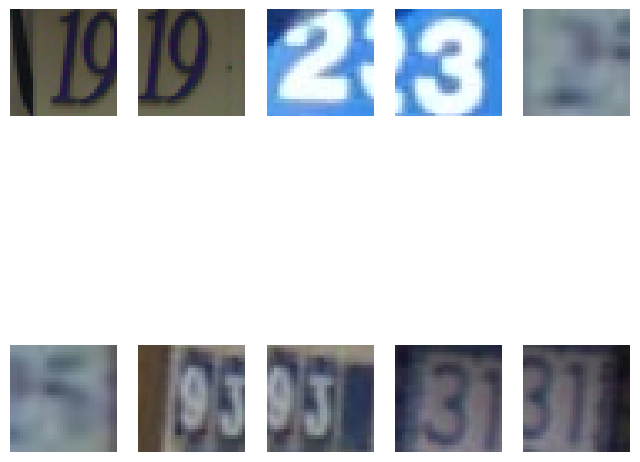

tensor([1, 9, 2, 3, 2, 5, 9, 3, 3, 1])


In [9]:
# display images and their corresponding labels.
display_images(train_image_batch, 2, 5)
print(classe_set[:10])
del train_image_batch, classe_set, train_set, train_loader, test_set

Let us add noise to the dataset and visualize the noisy images. In addition, we only want to load the images in the classes {0, 1, 2, 3, 4} instead of all the images.

In [10]:
# To add noise to images, we can take advantage of the transform module.
# We have defined custom transform class Noise to add noise during image transformation
class Noise(object):
    # Here we create a noisy version of the data set
    # The way that we do it is we go over all the pixels of
    # each of the data points; then with probability p we multiply
    # the value of that pixel by 0 (making it essentially black).
    # Otherwise (with probability 1-p) we multiply the value of that
    # pixel by 1 (essentially keeping the pixel untouched)

    # drop_probability is basically the probability of dropping a pixel (p in the above)
    # This is how we create the noisy data set.
    # Convert image_set to a numpy array
    def __init__(self, drop_probability=0):
        self.drop_probability = drop_probability

    def __call__(self, tensor):
        n = torch.from_numpy(np.random.choice([0, 1], size=tensor.size(), p=[self.drop_probability, 1-self.drop_probability]))
        return tensor * n

    def __repr__(self):
        return self.__class__.__name__ + '(drop_probability={0})'.format(self.drop_probability)

# Return transform function to convert an image into a tensor.
# Add noise if drop_probability is provided.
def generateTransform(drop_probability):
  if drop_probability is not None and drop_probability > 0:
    trans_noise = transforms.Compose([
                              transforms.ToTensor(),
                              Noise(drop_probability)
                              ])
    return trans_noise
  else:
    return transforms.Compose([transforms.ToTensor()])

# Load first 5 classes from SVHN digit dataset
def load_svhn_first_5_classes(train, transform=[]):
  split = 'train' if train else 'test'
  # it will try to download the dataset if dataset is not found under the root directory
  dataset = datasets.SVHN(root='./data', split=split, download=True, transform=transform)
  idx = dataset.labels < 5
  dataset.labels = dataset.labels[idx]
  dataset.data = dataset.data[idx]

  return dataset

Using downloaded and verified file: ./data/train_32x32.mat


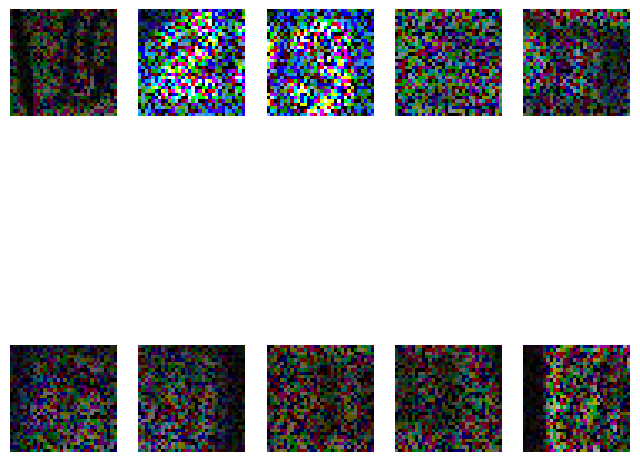

tensor([1, 2, 3, 2, 3, 3, 1, 3, 3, 2])


In [11]:
# Load training dataset and add noise
train_set = load_svhn_first_5_classes(train=True, transform=generateTransform(drop_probability=0.5))

# Add dataset to pytorch DataLoader with mini-batch size 64 s.t. each batch contains 64 images.
train_loader = DataLoader(train_set, batch_size=64, shuffle=False)

# Get first batch of images and labels
train_image_batch, classe_set = next(iter(train_loader))

# display noised images and their corresponding labels.
display_images(train_image_batch, 2, 5)
print(classe_set[0:10])
del train_image_batch, classe_set, train_set, train_loader

We can use GPU to train a neural network in order to speed up the training.

In [12]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available.")
else:
    device = torch.device("cpu")
    print("GPU is not available. Using CPU.")

GPU is not available. Using CPU.


# Task 1: SVHN Denoising with Convolution Neural Network (CNN) (30 points).
Convolutional Neural Network(CNN) have been quite successful in the field of image processing. In this part, you are asked to finish the implementation of the CNN model and use the model to denoise images from SVHN. Namely, the CNN model will take noisy images as input and output the denoised verion of the corresponding images.




## **A (20 points)** Create CNN
Finish the implementation of the CNN based on the requirements in the comments.


A convolutional layer can be implemented in pytorch like

```
nn.Conv2d(in_channels=, out_channels=, kernel_size=, padding=, stride=).
```

In [14]:
class MyCNN(nn.Module):
  # We create a CNN with 2 conv layers.
  # First conv is configured with filters(kernels) size 3, padding 1, and stride 1.
  # The first conv's inputs are images in dimension 32*32*3 (W*H*3).
  # Its output is in dimension 32*32*10 (W1*H1*num_feature_maps), where
      # W1=(W-Filter+2*Padding)/Stride+1 => 32=(32-3+2)/1+1.
      # H1=(H-Filter+2*Padding)/Stride+1 => 32=(32-3+2)/1+1.
  # Apply activation function ReLU to the first conv output.
  # Pass the result as input to the second conv layer.
  # The second conv is configured with the same filters and has out_channels
  # equal to num_output_channels.
  # Apply activation function Sigmoid to the second conv output.
    def __init__(self):
        super(MyCNN, self).__init__()

        self.num_input_channels = 3 # number of input image channel,
                                # 1 for grayscale images, 3 for color images
        self.num_output_channels = 3 # number of output image channel
        self.num_feature_maps = 30 # number of feature maps

        self.kernel_size = 3
        self.padding = 1
        self.stride = 1


        # To do:
        # Define the 2 conv layers
        self.conv1 = nn.Conv2d(in_channels=self.num_input_channels, 
                               out_channels=self.num_feature_maps, 
                               kernel_size=self.kernel_size, 
                               padding=self.padding, 
                               stride=self.stride)

        self.conv2 = nn.Conv2d(in_channels=self.num_feature_maps, 
                               out_channels=self.num_output_channels, 
                               kernel_size=self.kernel_size, 
                               padding=self.padding, 
                               stride=self.stride)

        # Activation functions
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Apply first conv layer and ReLU
        x = self.relu(self.conv1(x))

        # Apply second conv layer and Sigmoid
        x = self.sigmoid(self.conv2(x))

        return x

**(5 points)** How many parameters does MyCNN has?

The parameters of the conv1:
Parameters_{conv1} = 3 * 3 * 3 * 30 + 30 = 840

The parameters of the conv2:
Parameters_{conv2} = 3 * 3 * 30 * 3 + 3 = 813

Total number of parameters:
Parameters_{total} = Parameters_{conv1} + Parameters_{conv2} = 840 + 813 = 1653

## Create Dataloader
 The objective of tasks in the assignment is to train a network that, given a noisy image, recovers the original image. Therefore, each training point consists of the input (noisy image) and the expected output (true image). We will create pytorch dataloaders such that every element of the data loader is a pair of true image and noisy image.

In [17]:
# Function to create data loaders given the batch size
# Drop_probablity is used to control noise level
# importFunc accepts function as value
def load_data(batch_size, drop_probability=0.1, importFunc=load_svhn_first_5_classes):
  # Import train and test datasets.
  # Import train set without adding noise.
  train_set = importFunc(train=True, transform=generateTransform(0))
  # Use only the first 1500 points for training
  train_set = torch.utils.data.Subset(train_set, list(range(1, 1500)))

  # Import train set and add noise.
  train_set_noise = importFunc(train=True, transform=generateTransform(drop_probability))
  # Use only the first 1500 points for training
  train_set_noise = torch.utils.data.Subset(train_set_noise, list(range(1, 1500)))

  # Load the whole test dataset
  test_set = importFunc(train=False, transform=generateTransform(0))
  test_set = torch.utils.data.Subset(test_set, list(range(1, 1500)))
  test_set_noise = importFunc(train=False, transform=generateTransform(drop_probability))
  test_set_noise = torch.utils.data.Subset(test_set_noise, list(range(1, 1500)))

  # Create a new dataset storing image pairs,
  # an item in the dataset is a pair of images (original and noised).
  train_set = PairDataset(train_set, train_set_noise)
  test_set = PairDataset(test_set, test_set_noise)

  # Generate train and test dataloaders,
  # Dataloader is used to loop through data batches.
  train_loader = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size, shuffle=False)

  return train_loader, test_loader

# When get an item from the dataset, it returns a pair of data.
# In our case, it returns image and corresponding noised image.
class PairDataset(Dataset):
    def __init__(self, dataset_origin, dataset_noisy):
        self.dataset_origin = dataset_origin
        self.dataset_noisy = dataset_noisy

    def __getitem__(self, index):
        x1 = self.dataset_origin[index]
        x2 = self.dataset_noisy[index]
        return x1, x2

    def __len__(self):
        return len(self.dataset_origin)

## **B (30 points)** Denoise
1. Finish implementing train function which returns train/test losses over epochs.
2. Finish implementing test function which returns average test loss.
3. Denoise the SVHN images in the first 5 classes.

In [18]:
def train(train_loader, test_loader, model, epochs, loss_function, optimizer):
  train_loss_epochs = []
  test_loss_epochs = []

  # loop over the entire dataset #epochs times
  for epoch in range(epochs):
    train_loss_batches = []

    for i, (train_image_batch, train_noise_image_batch) in enumerate(iter(train_loader)):
      # Move model and data to GPU
      model = model.to(device)
      train_noise_image_batch = train_noise_image_batch[0].to(device)
      train_image_batch = train_image_batch[0].to(device)

      # set model to training mode
      model.train()

      # Below, we update weights(parameters).
      # We pass the inputs through the model, compute the loss, and backpropogate the error.

      # pytorch optimizer accumulates gradient values.
      # zero out the gradient before backpropogate.
      optimizer.zero_grad()

      # To do:
      # Denoise train_noise_image_batch with model.
      # Calculate training loss - call loss function loss_function to compare
      # L1 distance between denoised images and original images in train_image_batch.
      # Save the loss value to variable 'loss'.
      # Call backward() on loss variable and step() on optimizer to compute
      # gradient and update model parameters.
      # Denoise train_noise_image_batch with model.
      denoised_output = model(train_noise_image_batch)

      loss = loss_function(denoised_output, train_image_batch)

      loss.backward()
      optimizer.step()

      # Add the average loss of the batch to the total loss
      train_loss_batches.append(loss.item())


      # display denoised images every 5 epochs
      if epoch % 5==0 and i== len(train_loader)-1:
        print('Noisy images:')
        display_images(train_noise_image_batch[0:10].cpu(), 1, 10)
        print('Denoised images:')
        mlp_output = model(train_noise_image_batch[0:10].to(device))
        display_images(mlp_output.detach().cpu(), 1, 10)
        plt.show()


    # obtain test and train loss every epoch for analysis
    test_loss_epoch = test(test_loader, model, loss_function)
    train_loss_epoch = np.mean(train_loss_batches)

    train_loss_epochs.append(train_loss_epoch)
    test_loss_epochs.append(test_loss_epoch)

    print(f'Epoch {epoch+1} - Train loss on the SVHN train set : {train_loss_epoch}')
    print(f'Epoch {epoch+1} - Test loss on the SVHN test set : {test_loss_epoch}')

  return train_loss_epochs, test_loss_epochs

In [19]:
def test(dataloader, model, loss_function):
  # This is our test function. We pass all the testing data
  # through the Network and compute the loss.
  train_loss_batches = []
  model.to(device)

  # Set model to eval mode.
  model.eval()

  with torch.no_grad():
    for image_batch, noise_image_batch in iter(dataloader):
      # your code
      inputs = noise_image_batch[0].to(device)
      targets = image_batch[0].to(device)

      # To do:
      # Denoise noised images
      # Calculate loss with loss_function
      # Save the loss to variable 'test_loss'
      denoised_output = model(inputs)

      test_loss = loss_function(denoised_output, targets)


      train_loss_batches.append(test_loss.item())

  return np.mean(train_loss_batches)

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat
Noisy images:


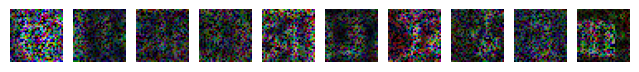

Denoised images:


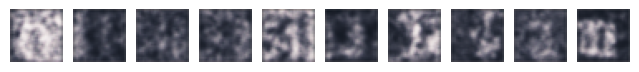

Epoch 1 - Train loss on the SVHN train set : 0.12941390834748745
Epoch 1 - Test loss on the SVHN test set : 0.08369402308017015
Epoch 2 - Train loss on the SVHN train set : 0.07837722233186166
Epoch 2 - Test loss on the SVHN test set : 0.07525738577047984
Epoch 3 - Train loss on the SVHN train set : 0.07079253811389208
Epoch 3 - Test loss on the SVHN test set : 0.0714136849467953
Epoch 4 - Train loss on the SVHN train set : 0.07034277295072873
Epoch 4 - Test loss on the SVHN test set : 0.07230618006239335
Epoch 5 - Train loss on the SVHN train set : 0.06908221263438463
Epoch 5 - Test loss on the SVHN test set : 0.0702944917914768
Noisy images:


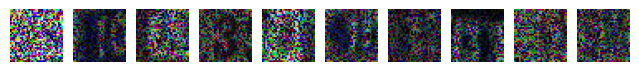

Denoised images:


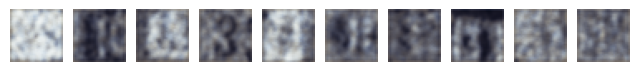

Epoch 6 - Train loss on the SVHN train set : 0.06848121869067351
Epoch 6 - Test loss on the SVHN test set : 0.06974831487362583
Epoch 7 - Train loss on the SVHN train set : 0.06828380872805913
Epoch 7 - Test loss on the SVHN test set : 0.06875936981911461
Epoch 8 - Train loss on the SVHN train set : 0.06730277587970097
Epoch 8 - Test loss on the SVHN test set : 0.06954565489043792
Epoch 9 - Train loss on the SVHN train set : 0.06663306088497241
Epoch 9 - Test loss on the SVHN test set : 0.06746795742462079
Epoch 10 - Train loss on the SVHN train set : 0.06692944141104817
Epoch 10 - Test loss on the SVHN test set : 0.06950686126947403
Noisy images:


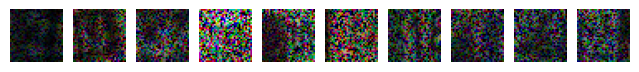

Denoised images:


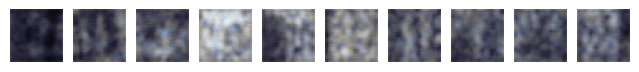

Epoch 11 - Train loss on the SVHN train set : 0.06667891377583146
Epoch 11 - Test loss on the SVHN test set : 0.06910297538464268
Epoch 12 - Train loss on the SVHN train set : 0.06628146022558212
Epoch 12 - Test loss on the SVHN test set : 0.06865097458163898
Epoch 13 - Train loss on the SVHN train set : 0.0656928204310437
Epoch 13 - Test loss on the SVHN test set : 0.07034170860424638
Epoch 14 - Train loss on the SVHN train set : 0.06625752337276936
Epoch 14 - Test loss on the SVHN test set : 0.06469428663452466
Epoch 15 - Train loss on the SVHN train set : 0.06221938350548347
Epoch 15 - Test loss on the SVHN test set : 0.061321699215720095
Noisy images:


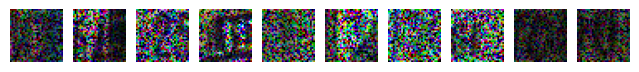

Denoised images:


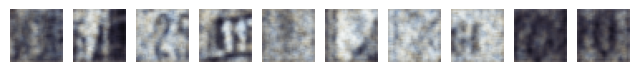

Epoch 16 - Train loss on the SVHN train set : 0.06071068967382113
Epoch 16 - Test loss on the SVHN test set : 0.06149737350642681
Epoch 17 - Train loss on the SVHN train set : 0.06060677425314983
Epoch 17 - Test loss on the SVHN test set : 0.07023761266221602
Epoch 18 - Train loss on the SVHN train set : 0.05999915146579345
Epoch 18 - Test loss on the SVHN test set : 0.05716092294702927
Epoch 19 - Train loss on the SVHN train set : 0.05667524365708232
Epoch 19 - Test loss on the SVHN test set : 0.058077148627489805
Epoch 20 - Train loss on the SVHN train set : 0.05524246798207363
Epoch 20 - Test loss on the SVHN test set : 0.054469014362742506
Noisy images:


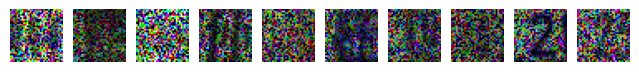

Denoised images:


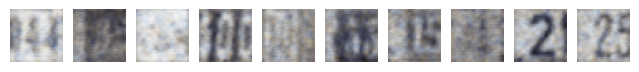

Epoch 21 - Train loss on the SVHN train set : 0.05882769621287783
Epoch 21 - Test loss on the SVHN test set : 0.05567229570200046
Epoch 22 - Train loss on the SVHN train set : 0.05316965670014421
Epoch 22 - Test loss on the SVHN test set : 0.05281561426818371
Epoch 23 - Train loss on the SVHN train set : 0.05450349083791176
Epoch 23 - Test loss on the SVHN test set : 0.05366360256448388
Epoch 24 - Train loss on the SVHN train set : 0.04968801746144891
Epoch 24 - Test loss on the SVHN test set : 0.049093093567838274
Epoch 25 - Train loss on the SVHN train set : 0.04774999339133501
Epoch 25 - Test loss on the SVHN test set : 0.0467320024035871


In [20]:
# Create a fresh model
model_task1 = MyCNN()

# Adam and SGD are two commonly used optimizers.
# We use Adam here.
optimizer = torch.optim.Adam(model_task1.parameters(), lr=0.05)

# L1 loss function
loss_function = nn.L1Loss()

# Load data
train_loader, test_loader = load_data(batch_size=64, drop_probability=0.5)

# Train the model
train_loss_epochs, test_loss_epochs = train(train_loader, test_loader, model_task1, 25, loss_function, optimizer)

## **C (10 points)** Plot train and test losses

In [21]:
# Plot test/train losses/accuracies over the number of epochs.
# Set description to 'Loss' or 'Accuracy' based on the use scenario.
def plot_eval_results(train_log_epochs, test_log_epochs, description='Loss'):
  plt.figure(figsize=(6, 4))

  # To do:
  # Define x axis variable
  # Finish defining plt.plot functions for test and train logs.
  # x =
  # plt.plot()  # Plot some data on the axes.
  # plt.plot()  # Plot some data on the axes.
  epochs = len(train_log_epochs)
  x = range(1, epochs + 1)

  plt.plot(x, train_log_epochs, label='Train ' + description)
  plt.plot(x, test_log_epochs, label='Test ' + description)


  plt.xlabel('#Epochs')  # Add an x-label to the axes.
  plt.ylabel(description)  # Add a y-label to the axes.
  plt.title("Report")  # Add a title to the axes.
  plt.legend()  # Add a legend.

  plt.show()

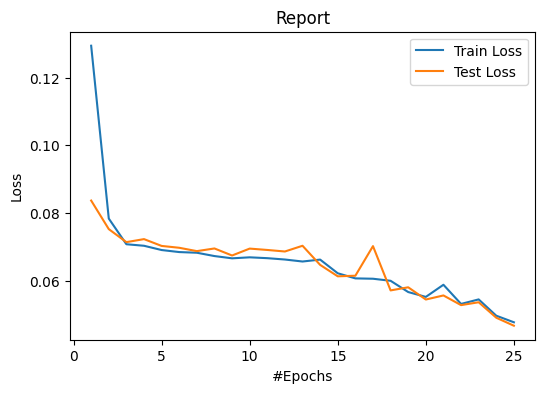

In [22]:
plot_eval_results(train_loss_epochs, test_loss_epochs, description='Loss')

## **D (15 points)** Denoise the last 5 classes
We have trained our model using the images from the first 5 {0, 1, 2, 3, 4} classes. In this question, we will test the performance of the model on the images from the last 5 {5, 6, 7, 8, 9} classes that the model has never 'seen' before.

1. Finish implementing load_svhn_last_5_classes to load SVHN images in the last 5 classes.
2. Obtain denoising loss (L1 loss) against test dataset for the loaded data.
3. Visualize the denoised images.

In [23]:
# Load the last 5 classes from SVHN digit dataset
def load_svhn_last_5_classes(train=True, transform=[]):
  # To do:
  # Load SVHN dataset (train or test based on argument 'train').
  # Return the images in the dataset with label greater or equal to 5.
  split = 'train' if train else 'test'
  dataset = datasets.SVHN(root='./data', split=split, download=True, transform=transform)

  idx = (dataset.labels >= 5) & (dataset.labels <= 9)
  dataset.data = dataset.data[idx]
  dataset.labels = dataset.labels[idx]

  return dataset

In [24]:
# Load train and test data.
_, test_loader = load_data(batch_size=64, importFunc=load_svhn_last_5_classes)
print(f'test_loader has {len(test_loader)} batches')
loss_function = nn.L1Loss()
loss = test(test_loader, model_task1, loss_function)
print(f'model_task1 loss is {loss}')

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat
test_loader has 24 batches
model_task1 loss is 0.06260783566782872


Original images:


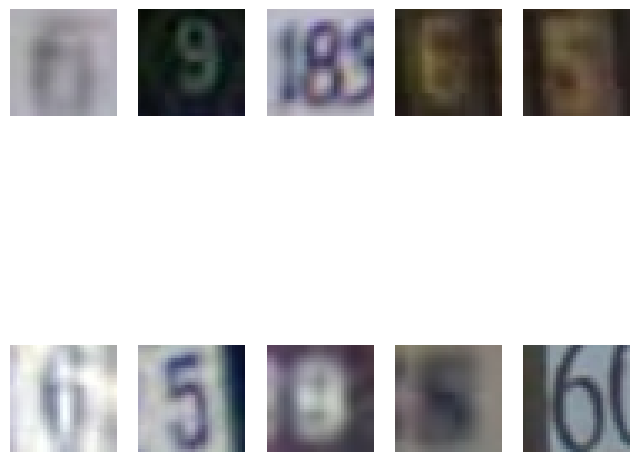

Noisy images:


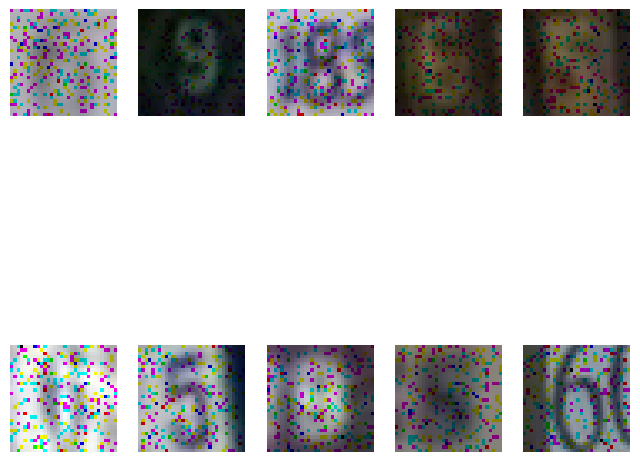

Denoised images:


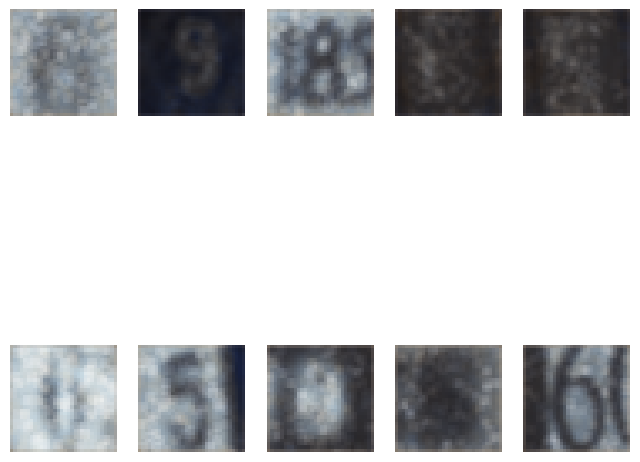

In [26]:
image_batch, noise_image_batch = next(iter(test_loader))
image_batch = image_batch[0]
noise_image_batch = noise_image_batch[0]
model_task1.cpu()

with torch.no_grad():
  # To do:
  # Display the first 10 original images with function display_images.
  print('Original images:')
  display_images(image_batch[:10], 2, 5)

  # Display the first 10 noisy images.
  print('Noisy images:')
  display_images(noise_image_batch[:10], 2, 5)

  # Denoise the first 10 noisy images with model_task1 and display them.
  print('Denoised images:')
  denoised_images = model_task1(noise_image_batch[:10])
  display_images(denoised_images, 2, 5)

  plt.show()

# Task 2: SVHN Classification with Convolution Neural Network (CNN) (45 points).
In this part, you are asked to finish implementing the CNN model and use the model to classify SVHN images.



## **A (10 points)** Create CNN
In this part we are going to finish implementing the CNN model by defining the 3 conv layers. The charactristics of the conv layers are as follows:


* three conv layers
* each conv layer has filters configured as kernel_size=3, stride=1, padding=1
* the first layer has 32 output channels.
* the second layer has 64 output channels.
* the third layer has 128 output channels.


In [27]:
class SVHN_CNN(nn.Module):
    def __init__(self):
        super(SVHN_CNN, self).__init__()
        # To do:
        # Define convolutional layers based on the requirements.
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)

        # Max pooling layer reduces dimensions of inputs
        # It can help with issues like overfitting
        # and reduce the number of parameters (faster training)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.relu = nn.ReLU()

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 classes for SVHN

        # BatchNormalization normalize the inputs.
        # It can help to achieve the faster convergence
        # and better model generalization.
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)


    def forward(self, x):
        # Convolutional layers with ReLU activation and max pooling
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))

        # Flatten the output for fully connected layers
        x = x.view(-1, 128 * 4 * 4)

        # Fully connected layers with ReLU activation
        x = self.relu(self.fc1(x))
        return self.fc2(x)

## **B (35 points)** Train the network
In the part, we are going to train the SVHN_CNN model to classify SVHN dataset.
1. Finish implementing train procedure and test function.
2. Plot the train/test losses and train/test accuracies using the plot_eval_results function.


In [28]:
# Load SVHN datasets, and create pytorch data loader to read data in mini-batches
def get_data_loaders(learning_rate, batch_size):
  transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
  train_dataset = datasets.SVHN(root='./data', split='train', download=True, transform=transforms.ToTensor())
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_dataset = datasets.SVHN(root='./data', split='test', download=True, transform=transforms.ToTensor())
  test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

  return train_loader, test_loader

In [29]:
# Return model loss and accuracy with the provided criterion and data_loader.
def test(model, data_loader, criterion=None):
  model.eval()
  correct = 0
  total = 0
  loss_batches = []

  # Switch to evaluation mode and turn off gradient calculation
  # since parameters are not updated during testing.
  with torch.no_grad():
      for images_batch, labels_batch in data_loader:
          images_batch = images_batch.to(device)
          labels_batch = labels_batch.to(device)

          # To do:
          # Call model to predict labels for the images_batch
          # Use provided criterion to calculate 'loss' for the
          # predicted labels and true labels
          outputs = model(images_batch)
          loss = criterion(outputs, labels_batch)


          # Append the loss to loss_batches
          loss_batches.append(loss.item())

          # The predicted label is the output with the highest activation.
          _, predicted = torch.max(outputs.data, 1)
          total += labels_batch.size(0)
          correct += (predicted == labels_batch).sum().item()


  accuracy = 100 * correct / total
  loss = np.mean(loss_batches)

  model.train()

  return accuracy, loss

In [30]:
# Define loss function
# The CrossEntropyLoss in pytorch already have softmax included.
criterion = nn.CrossEntropyLoss()

# Hyperparameters
# Learning rate controls the step size of gradient descent
learning_rate = 0.05
# Number of epochs controls how many rounds of training will be done
num_epochs = 10
# Batch size controls the number of images in each mini-batch
batch_size = 64

# Load SVHN dataset
train_loader, test_loader = get_data_loaders(learning_rate, batch_size)

# To do:
# Initialize the SVHN_CNN model
# Define a SGD (Stochastic Gradient Descent) optimizer with learning_rate above.
model = SVHN_CNN()
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Training
train_loss_epochs = []
test_loss_epochs = []
train_accuracy_epochs = []
test_accuracy_epochs = []
for epoch in range(num_epochs):
    for i, (images_batch, labels_batch) in enumerate(train_loader):
        optimizer.zero_grad()
        images_batch = images_batch.to(device)
        labels_batch = labels_batch.to(device)

        # To do:
        # Call model to predict labels for the images_batch
        # Use provided criterion to calculate 'loss' for the
        # predicted labels and true labels
        # Call backward() on loss variable and step() on optimizer
        # in order to calcualte gradient and update NN parameters.
        optimizer.zero_grad()
        outputs = model(images_batch)
        loss = criterion(outputs, labels_batch)

    # Obtain train/test loss values and accuracies after each epoch
    train_accuracy, train_loss = test(model, train_loader, criterion)
    test_accuracy, test_loss = test(model, test_loader, criterion)

    print(f'Epoch {epoch+1} - Train loss on the SVHN train set : {train_loss}')
    print(f'Epoch {epoch+1} - Train accuracy on the SVHN train set : {train_accuracy:.2f}%')
    print(f'Epoch {epoch+1} - Test loss on the SVHN test set : {test_loss}')
    print(f'Epoch {epoch+1} - Test accuracy on the SVHN test set : {test_accuracy:.2f}%')

    train_loss_epochs.append(train_loss)
    test_loss_epochs.append(test_loss)
    train_accuracy_epochs.append(train_accuracy)
    test_accuracy_epochs.append(test_accuracy)

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat
Epoch 1 - Train loss on the SVHN train set : 2.3561360471633845
Epoch 1 - Train accuracy on the SVHN train set : 7.40%
Epoch 1 - Test loss on the SVHN test set : 2.3510041793382723
Epoch 1 - Test accuracy on the SVHN test set : 7.55%
Epoch 2 - Train loss on the SVHN train set : 2.3551261071034393
Epoch 2 - Train accuracy on the SVHN train set : 7.39%
Epoch 2 - Test loss on the SVHN test set : 2.349801726071782
Epoch 2 - Test accuracy on the SVHN test set : 7.53%
Epoch 3 - Train loss on the SVHN train set : 2.3573659551195703
Epoch 3 - Train accuracy on the SVHN train set : 7.38%
Epoch 3 - Test loss on the SVHN test set : 2.352170279336503
Epoch 3 - Test accuracy on the SVHN test set : 7.51%
Epoch 4 - Train loss on the SVHN train set : 2.356076472294903
Epoch 4 - Train accuracy on the SVHN train set : 7.40%
Epoch 4 - Test loss on the SVHN test set : 2.3509116940182024
Epo

**B (10 points)** Plot the train/test accuraies and losses with plot_eval_results function.

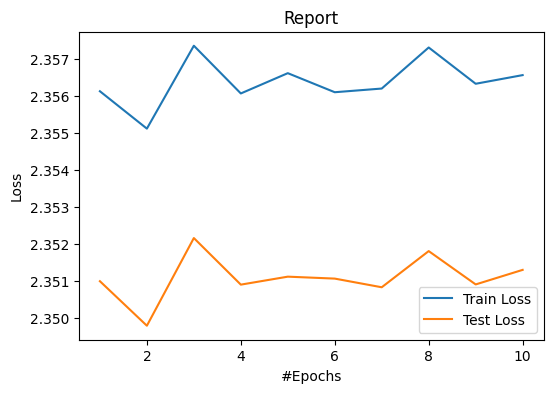

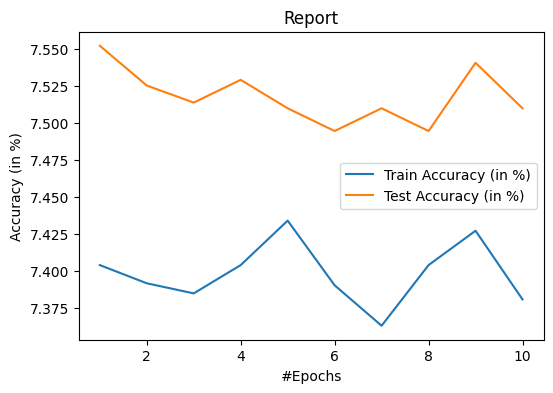

In [32]:
plot_eval_results(train_loss_epochs, test_loss_epochs, 'Loss')
plot_eval_results(train_accuracy_epochs, test_accuracy_epochs, 'Accuracy (in %)')